In [1]:
library(tidyverse)
library(cowplot)
library(arrow)
library(yardstick)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp



Attaching package: ‘arrow’


The following object is masked from ‘package:lubridate’:

    duration


The following object is masked from ‘package:utils’:

    timestamp



Attaching packag

In [2]:
dataset <- fs::dir_ls("plot_data") %>%
    sort %>%
    map(read_parquet) %>%
    list_rbind(names_to = "method") %>%
    mutate(
        method = method %>% 
            str_replace_all(c("plot_data/" = "", ".parquet" = "")) %>%
            recode_factor(
                univariate = "Univariate OLS",
                multivariate = "Multivariate OLS",
                fastgwa = "FastGWA",
                regenie = "Regenie"
            )
    )

dataset %>% head(2)

method,phenotype_id,variant_id,beta,std_error,chisq,log10p,sample_size,beta_indirect,std_error_indirect,chisq_indirect,log10p_indirect,sample_size_indirect
<fct>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
FastGWA,PROJ001,1:761147,-0.0169546,0.0236513,0.5138840,-0.3247140,99194,-0.01690192,0.02354397,0.5153625,0.3252965,99194
FastGWA,PROJ001,1:768448,-0.0205202,0.0273366,0.5634744,-0.3440332,100000,-0.02063725,0.02721258,0.5751276,0.3484988,100000


In [3]:
summary_df <- dataset %>%
    group_by(method) %>%
    summarize(rsq = rsq_vec(chisq, chisq_indirect)) %>%
    mutate(label = rsq %>% round(3) %>% str_c("R^2==", .))

summary_df

method,rsq,label
<fct>,<dbl>,<chr>
Univariate OLS,0.9999933,R^2==1
Multivariate OLS,0.9999500,R^2==1
FastGWA,0.9988629,R^2==0.999
Regenie,0.9740232,R^2==0.974


In [4]:
options(repr.plot.height = 2.25, repr.plot.width = 7, repr.plot.res = 250)

# set.seed(0)

validation_plot <- dataset %>%
    select(method, phenotype_id, variant_id, direct = chisq, indirect = chisq_indirect) %>%
    # slice_sample(prop = 0.5, by = c(method, phenotype_id)) %>%
    ggplot(aes(x = indirect, y = direct)) +
    geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "grey50") +
    geom_point(alpha = 0.1) +
    geom_text(data = summary_df, aes(label = label), x = -Inf, y = Inf, hjust = -0.1, vjust = 1.25, parse = TRUE) +
    facet_wrap(vars(method), scales = "free", nrow = 1) +
    theme_cowplot() +
    panel_border() +
    theme(
        strip.background = element_rect(fill = "white", color = "white"),
        axis.text.y = element_blank(),
        plot.margin = margin(7, 12, 7, 7)
    ) +
    xlab(expression("Indirect"~chi^2)) +
    ylab(expression("Direct"~chi^2)) +
    scale_x_continuous(breaks = c(0, 2000)) +
    scale_y_continuous(breaks = c(0, 2000))

In [5]:
save_plot("img/validation.png", validation_plot, base_height = 2.25, base_width = 7, dpi = 400)

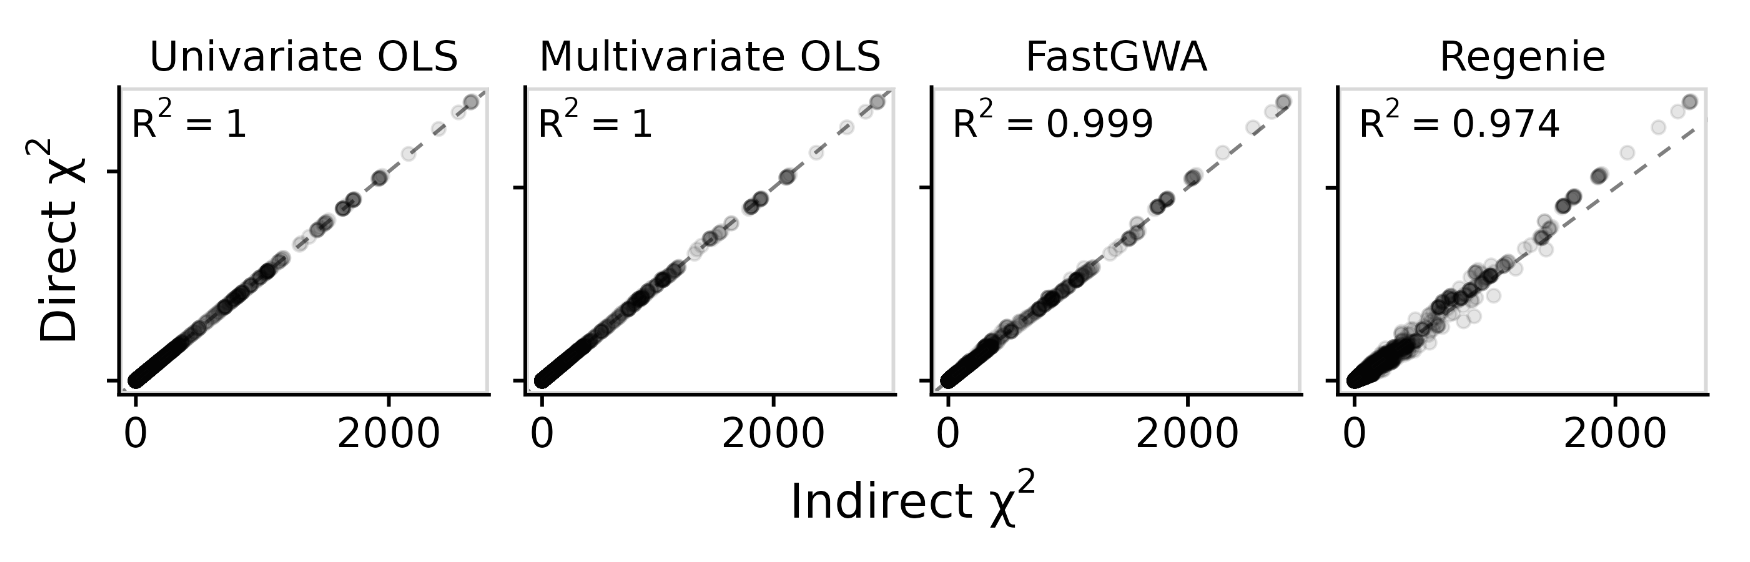

In [6]:
grid::grid.raster(png::readPNG("img/validation.png"))